In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from pathlib import Path
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib
import pickle
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, confusion_matrix
import xgboost as xgb

import comet_ml
from comet_ml import API

from helper_func import *

# 1. Download model

In [2]:
# Download a Registry Model:
api = API(api_key=os.environ.get('COMET_API_KEY'))
models_dir = Path("downloaded_models")

model = api.get_model(workspace=os.environ.get('workspace_name'), model_name="log_reg_dist")
model.download("1.0.0", output_folder=models_dir, expand=True)

model = api.get_model(workspace=os.environ.get('workspace_name'), model_name="log_reg_ang")
model.download("1.0.0", output_folder=models_dir, expand=True)

model = api.get_model(workspace=os.environ.get('workspace_name'), model_name="log_reg_dist_ang")
model.download("1.0.0", output_folder=models_dir, expand=True)

model = api.get_model(workspace=os.environ.get('workspace_name'), model_name='xgboost_best')
model.download("1.0.0", output_folder="downloaded_models", expand=True)

model = api.get_model(workspace=os.environ.get('workspace_name'), model_name='decision_tree')
model.download("1.0.0", output_folder=models_dir, expand=True)


# 2. Evaluate 2020 - regular season

In [3]:
path_test_regular_csv = os.path.join("Dataset", "test_regular.csv")
path_test_playoff_csv = os.path.join("Dataset", "test_playoff.csv")

In [4]:
# Load dataframe
df_test = pd.read_csv(path_test_regular_csv)
df_test.dropna(inplace=True)

### a. Baseline - shot distance

In [5]:
# Prepare dataset
list_features = ['shot_distance']

X_test = df_test[list_features]
y_test = df_test['isgoal']

# Predict
log_reg_dist = pickle.load(open(os.path.join('downloaded_models', 'log_reg_dist.sav'), "rb"))

y_test_pred_log_reg_dist = log_reg_dist.predict(X_test)
y_test_pred_proba_log_reg_dist = log_reg_dist.predict_proba(X_test)[:, 1]

# Evaluate
# accuracy = accuracy_score(y_test, y_test_pred_log_reg_dist)
# fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba_log_reg_dist)
# roc_auc = auc(fpr, tpr)

# print(f"Accuracy test set: {accuracy:.4f}")
# print(f'ROC: {roc_auc}')

/home/thaiv7/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### b. Baseline - angle

In [6]:
# Prepare dataset
list_features = ['angle']

X_test = df_test[list_features]
X_test.loc[:, "angle"] = X_test["angle"].apply(np.abs)
y_test = df_test['isgoal']

# Predict
log_reg_ang = pickle.load(open(os.path.join('downloaded_models', 'log_reg_ang.sav'), "rb"))

y_test_pred_log_reg_ang = log_reg_ang.predict(X_test)
y_test_pred_proba_log_reg_ang = log_reg_ang.predict_proba(X_test)[:, 1]

/home/thaiv7/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### c. Baseline - dist_ang

In [7]:
# Prepare dataset
list_features = ["shot_distance", "angle"]

X_test = df_test[list_features]
X_test.loc[:, "angle"] = X_test["angle"].apply(np.abs)
y_test = df_test['isgoal']

# Predict
log_reg_dist_ang = pickle.load(open(os.path.join('downloaded_models', 'log_reg_dist_ang.sav'), "rb"))

y_test_pred_log_reg_dist_ang = log_reg_dist_ang.predict(X_test)
y_test_pred_proba_log_reg_dist_ang = log_reg_dist_ang.predict_proba(X_test)[:, 1]

/home/thaiv7/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### e. XGBoost

In [8]:
# Load pre-process information
path_csv_train = os.path.join('Dataset', 'train.csv')
df = pd.read_csv(path_csv_train, index_col=0)
df = df.dropna()
train_data = df.drop(['isgoal', 'attackingSide', 'periodTime'], axis=1)
train_data['is_rebound'].replace({False: 0, True: 1}, inplace=True)
train_data = pd.get_dummies(train_data, columns=['last_event_type', 'shotType'], dtype=np.int32, drop_first=True)
train_data_min = train_data.min()
train_data_max = train_data.max()

# Load model
xgb_best = xgb.Booster()
xgb_best.load_model("downloaded_models/hptuned_model.json")

# Load testing data
test_label = df_test['isgoal']
test_data = df_test.drop(['isgoal', 'attackingSide', 'periodTime'], axis=1)
test_data['is_rebound'].replace({False: 0, True: 1}, inplace=True)
test_data = pd.get_dummies(test_data, columns=['last_event_type', 'shotType'], dtype=np.int32, drop_first=True)
test_data = (test_data - train_data_min) / (train_data_max - train_data_min) 

# Prepare data
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)
dtest = xgb.DMatrix(test_data, label=test_label)

# Inference
y_test_pred_proba_xgb = xgb_best.predict(dtest)
y_test_pred_xgb = (y_test_pred_proba_xgb > 0.5).astype(int)

### d. Decision tree

In [9]:
def Is_Shot_In_Attacking_Zone(x_coordinate_shot, attacking_side):

    if str(attacking_side).lower() == "left":
        x_coordinate_net = -89
        attacking_zone_range = -25
        return x_coordinate_net <= x_coordinate_shot <= attacking_zone_range
    elif str(attacking_side).lower() == "right":
        x_coordinate_net = 89
        attacking_zone_range = 25
        return  attacking_zone_range <= x_coordinate_shot <= x_coordinate_net
    else:
        return None

In [10]:
# Prepare dataset
df_test['attacking_zone_shot'] = df_test.apply(lambda x: Is_Shot_In_Attacking_Zone(x['x-coordinate'], x['attackingSide']), axis=1)

list_features = ['x-coordinate', 'y-coordinate', 'shot_distance', 'angle', 'isEmptyNet', 'n_friend',\
                 'n_oppose', 'last_event_type', 'is_rebound', 'attacking_zone_shot']

X_test = df_test[list_features]
y_test = df_test['isgoal']

# Predict
decision_tree = joblib.load(os.path.join('downloaded_models', 'decision_tree.pkl'))

y_test_pred_tree = decision_tree.predict(X_test)
y_test_pred_proba_tree = decision_tree.predict_proba(X_test)[:, 1]

# # Evaluate
# accuracy = accuracy_score(y_test, y_test_pred_tree)
# fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba_tree)
# roc_auc = auc(fpr, tpr)

# print(f"Accuracy test set: {accuracy:.4f}")
# print(f'ROC: {roc_auc}')

### d. Visualization

In [11]:
probs = [y_test_pred_proba_log_reg_dist, y_test_pred_proba_log_reg_ang, y_test_pred_proba_log_reg_dist_ang,\
         y_test_pred_proba_xgb, y_test_pred_proba_tree]
models = ['log_reg_dist', 'log_reg_ang', 'log_reg_dist_ang', 'xgboost', 'decision tree']

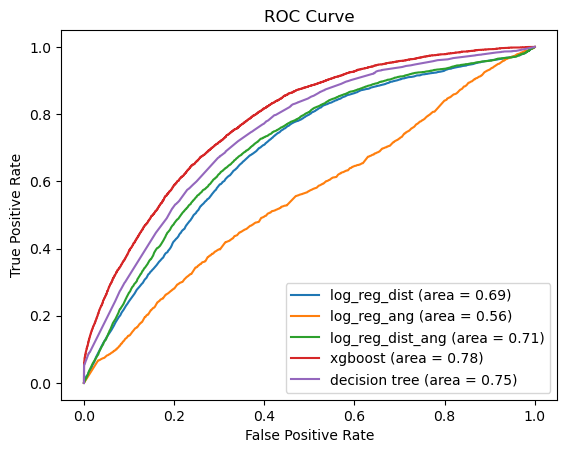

In [12]:
path_output_image = os.path.join("images", "evaluation", "roc_test_regular.jpg")
Visualize_ROC(models, probs, y_test, path_output_image)

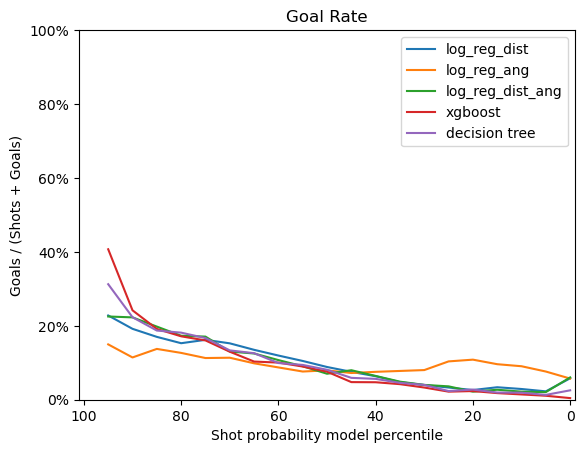

In [13]:
path_output_image = os.path.join("images", "evaluation", "goal_rate_test_regular.jpg")
Visualize_Goal_Rate(models, probs, y_test, path_output_image)

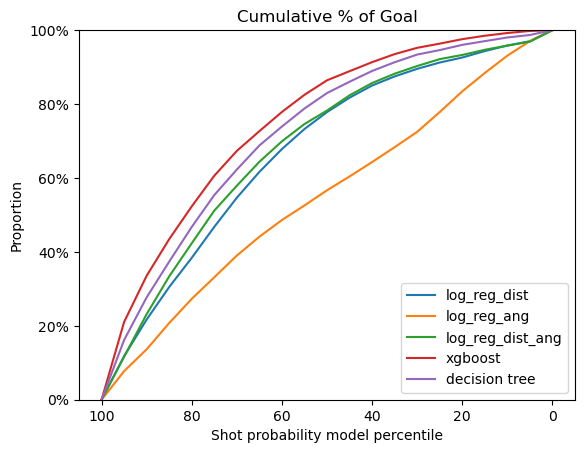

In [14]:
path_output_image = os.path.join("images", "evaluation", "cumulative_proportion_test_regular.jpg")
Visualize_Cumulative_Proportion(models, probs, y_test, path_output_image)

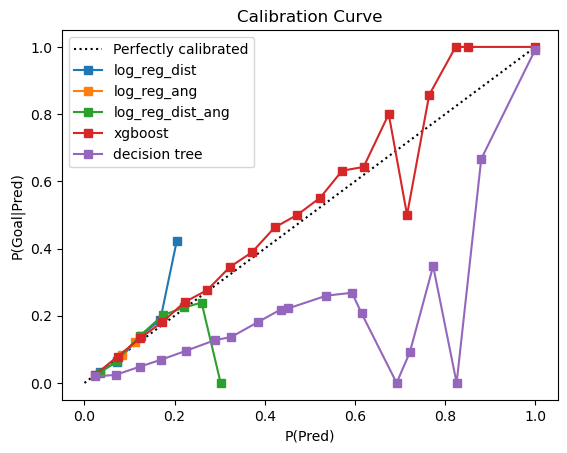

In [15]:
path_output_image = os.path.join("images", "evaluation", "calibration_test_regular.jpg")
Visualize_Calibration(models, probs, y_test, path_output_image)

# 3. Evaluate 2020 - playoff season

In [16]:
df_test = pd.read_csv(path_test_playoff_csv)
df_test.dropna(inplace=True)

### a. Baseline - shot distance

In [17]:
# Prepare dataset
list_features = ['shot_distance']

X_test = df_test[list_features]
y_test = df_test['isgoal']

# Predict
log_reg_dist = pickle.load(open(os.path.join('downloaded_models', 'log_reg_dist.sav'), "rb"))

y_test_pred_log_reg_dist = log_reg_dist.predict(X_test)
y_test_pred_proba_log_reg_dist = log_reg_dist.predict_proba(X_test)[:, 1]

/home/thaiv7/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### b. Baseline - angle

In [18]:
# Prepare dataset
list_features = ['angle']

X_test = df_test[list_features]
X_test.loc[:, "angle"] = X_test["angle"].apply(np.abs)
y_test = df_test['isgoal']

# Predict
log_reg_ang = pickle.load(open(os.path.join('downloaded_models', 'log_reg_ang.sav'), "rb"))

y_test_pred_log_reg_ang = log_reg_ang.predict(X_test)
y_test_pred_proba_log_reg_ang = log_reg_ang.predict_proba(X_test)[:, 1]

/home/thaiv7/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### c. Baseline - dist_ang

In [19]:
# Prepare dataset
list_features = ["shot_distance", "angle"]

X_test = df_test[list_features]
X_test.loc[:, "angle"] = X_test["angle"].apply(np.abs)
y_test = df_test['isgoal']

# Predict
log_reg_dist_ang = pickle.load(open(os.path.join('downloaded_models', 'log_reg_dist_ang.sav'), "rb"))

y_test_pred_log_reg_dist_ang = log_reg_dist_ang.predict(X_test)
y_test_pred_proba_log_reg_dist_ang = log_reg_dist_ang.predict_proba(X_test)[:, 1]

/home/thaiv7/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### d. XGBoost

In [20]:
# Load testing data
test_label = df_test['isgoal']
test_data = df_test.drop(['isgoal', 'attackingSide', 'periodTime'], axis=1)
test_data['is_rebound'].replace({False: 0, True: 1}, inplace=True)
test_data = pd.get_dummies(test_data, columns=['last_event_type', 'shotType'], dtype=np.int32, drop_first=True)
test_data = (test_data - train_data_min) / (train_data_max - train_data_min) 

# Prepare data
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)
dtest = xgb.DMatrix(test_data, label=test_label)

# Inference
y_test_pred_proba_xgb = xgb_best.predict(dtest)
y_test_pred_xgb = (y_test_pred_proba_xgb > 0.5).astype(int)

### d. Decision tree

In [22]:
def Is_Shot_In_Attacking_Zone(x_coordinate_shot, attacking_side):

    if str(attacking_side).lower() == "left":
        x_coordinate_net = -89
        attacking_zone_range = -25
        return x_coordinate_net <= x_coordinate_shot <= attacking_zone_range
    elif str(attacking_side).lower() == "right":
        x_coordinate_net = 89
        attacking_zone_range = 25
        return  attacking_zone_range <= x_coordinate_shot <= x_coordinate_net
    else:
        return None

In [23]:
# Prepare dataset
df_test['attacking_zone_shot'] = df_test.apply(lambda x: Is_Shot_In_Attacking_Zone(x['x-coordinate'], x['attackingSide']), axis=1)

list_features = ['x-coordinate', 'y-coordinate', 'shot_distance', 'angle', 'isEmptyNet', 'n_friend',\
                 'n_oppose', 'last_event_type', 'is_rebound', 'attacking_zone_shot']

X_test = df_test[list_features]
y_test = df_test['isgoal']

# Predict
decision_tree = joblib.load(os.path.join('downloaded_models', 'decision_tree.pkl'))

y_test_pred_tree = decision_tree.predict(X_test)
y_test_pred_proba_tree = decision_tree.predict_proba(X_test)[:, 1]

### d. Visualization

In [24]:
probs = [y_test_pred_proba_log_reg_dist, y_test_pred_proba_log_reg_ang, y_test_pred_proba_log_reg_dist_ang,\
         y_test_pred_proba_xgb, y_test_pred_proba_tree]
models = ['log_reg_dist', 'log_reg_ang', 'log_reg_dist_ang', 'xgboost', 'decision tree']

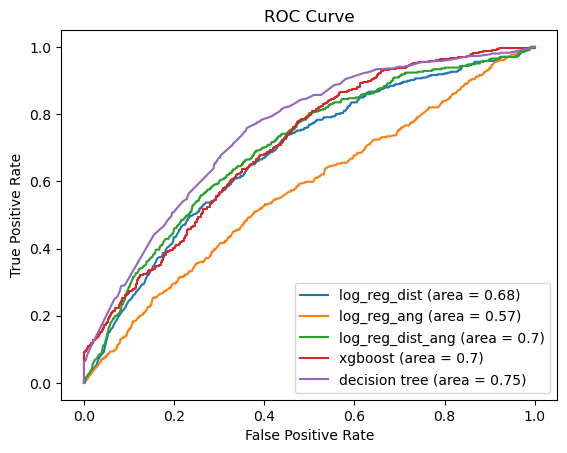

In [25]:
path_output_image = os.path.join("images", "evaluation", "roc_test_playoff.jpg")
Visualize_ROC(models, probs, y_test, path_output_image)

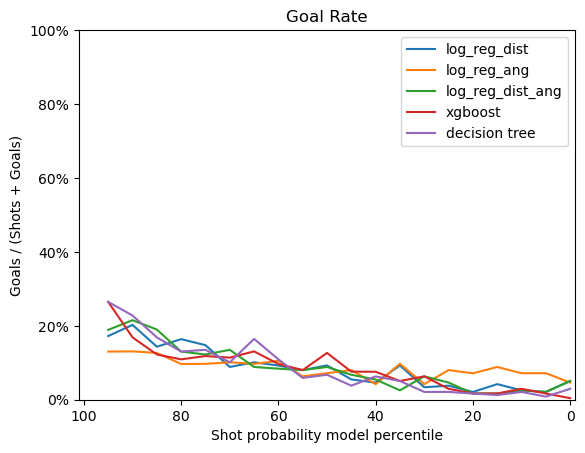

In [26]:
path_output_image = os.path.join("images", "evaluation", "goal_rate_test_playoff.jpg")
Visualize_Goal_Rate(models, probs, y_test, path_output_image)

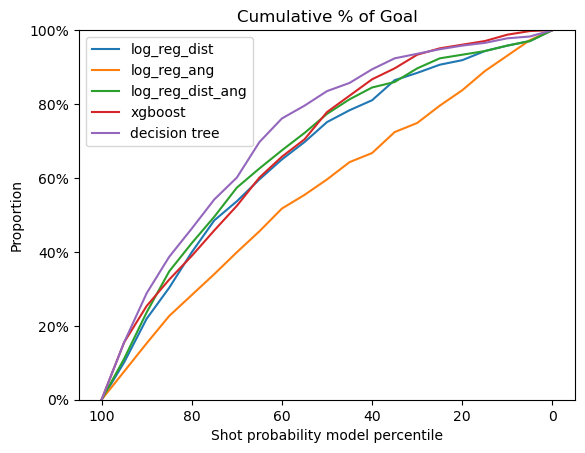

In [27]:
path_output_image = os.path.join("images", "evaluation", "cumulative_proportion_test_playoff.jpg")
Visualize_Cumulative_Proportion(models, probs, y_test, path_output_image)

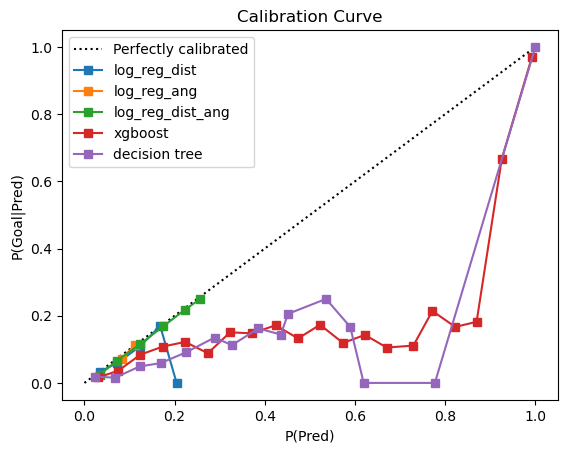

In [28]:
path_output_image = os.path.join("images", "evaluation", "calibration_test_playoff.jpg")
Visualize_Calibration(models, probs, y_test, path_output_image)